In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, 
    confusion_matrix, precision_score, recall_score, log_loss, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from venn_abers import VennAbersCalibrator
from xgboost import XGBClassifier



In [2]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve
import seaborn as sns

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp+fn)>0 else 0
    specificity = tn / (tn + fp) if (tn+fp)>0 else 0
    return 0.5 * (sensitivity + specificity)

def model_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "ROC_AUC": roc_auc_score(y_true, y_prob),
        "Balanced_Accuracy": balanced_accuracy(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "LogLoss": log_loss(y_true, y_prob),
    }

def calibration_metrics(y_true, y_proba, method_name):
    logloss = log_loss(y_true, y_proba)
    brier   = brier_score_loss(y_true, y_proba)
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)
    ece = np.abs(prob_true - prob_pred).mean()
    return {"Method": method_name, "Log Loss": logloss, "Brier Score": brier, "ECE": ece}


In [3]:
TRAIN_PATH = "DATA/preprocessed_train.csv"
VALID_PATH = "DATA/preprocessed_valid.csv"
TEST_PATH  = "DATA/preprocessed_test.csv"

In [4]:
df_tr = pd.read_csv(TRAIN_PATH)
df_va = pd.read_csv(VALID_PATH)
df_te = pd.read_csv(TEST_PATH)

In [5]:
df_tr.head()

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,ID
0,37200,3,4.0,6,1,9000,0,0.24,1,6,23482
1,83000,3,0.0,2,4,14000,1,0.17,2,4,14094
2,50000,3,1.0,5,1,4000,0,0.08,1,2,3966
3,43200,2,4.0,1,1,6350,0,0.15,1,4,5052
4,70000,3,6.0,3,4,12000,0,0.17,2,5,25312


In [6]:
df_tr.shape


(20745, 11)

In [46]:
TARGET = "loan_status"
ID_COL = "ID"

X_tr = df_tr.drop(columns=[TARGET, ID_COL])
y_tr = df_tr[TARGET]

X_va = df_va.drop(columns=[TARGET, ID_COL])
y_va = df_va[TARGET]  

X_te = df_te.drop(columns=[TARGET, ID_COL])
y_te = df_te[TARGET]


pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / max(pos, 1)  

xgb_model = XGBClassifier(
    n_estimators=50,        
    learning_rate=0.1,
    max_depth=7,
   # subsample=0.8,
    #colsample_bytree=0.8,
  #  eval_metric="auc",    
#    scale_pos_weight=scale_pos_weight,
 #   early_stopping_rounds=10, 
)

In [47]:
import xgboost
print(xgboost.__version__)


3.0.4


In [48]:
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=False,
)
proba_va = xgb_model.predict_proba(X_va)[:, 1]
y_pred  = (proba_va >= 0.5).astype(int)



In [49]:
proba_tr = xgb_model.predict_proba(X_tr)[:, 1]
y_pred_tr  = (proba_tr >= 0.5).astype(int)


In [50]:
roc_auc_score(y_tr, proba_tr)

0.9563266351107271

In [51]:
proba_te = xgb_model.predict_proba(X_te)[:, 1]
y_pred  = (proba_te >= 0.47).astype(int)

In [52]:
roc_auc_score(y_te, proba_te)

0.9382280225364533

In [53]:
roc_auc_score(y_va, proba_va)

0.9420361956887542

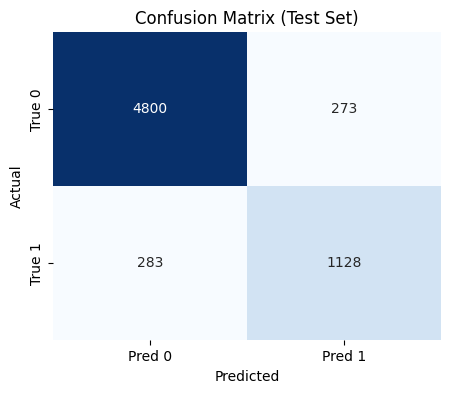

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [20]:
import sklearn 

print(sklearn.__version__)

1.7.1


In [55]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
from venn_abers import VennAbersCalibrator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Prefit calibration models (validation set) ---
platt = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
platt.fit(X_va, y_va)

isotonic = CalibratedClassifierCV(estimator=xgb_model, method="isotonic", cv="prefit")
isotonic.fit(X_va, y_va)


VAC = VennAbersCalibrator()
p_cal = xgb_model.predict_proba(X_va)
p_test = xgb_model.predict_proba(X_te)
predictions_IVAP, intervals = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_test, p0_p1_output=True)


X_cvap = pd.concat([X_tr, X_va], axis=0)
y_cvap = pd.concat([y_tr, y_va], axis=0)

# --- CVAP (cross Venn–Abers) ---
va_cross = VennAbersCalibrator(
    estimator=XGBClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=7,
        #subsample=0.8,
        #colsample_bytree=0.8,
        #eval_metric="auc",
       # scale_pos_weight=scale_pos_weight
    ),
    inductive=False,
    n_splits=5,   
    random_state=42
)

va_cross.fit(X_cvap, y_cvap)

p_va_cross = va_cross.predict_proba(X_te)
p_va_cross = p_va_cross[:, 1] if p_va_cross.ndim == 2 else p_va_cross

proba_raw   = xgb_model.predict_proba(X_te)[:,1]
proba_platt = platt.predict_proba(X_te)[:,1]
proba_iso   = isotonic.predict_proba(X_te)[:,1]



/Users/sezermezgil/anaconda3/envs/tf_m1/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/sezermezgil/anaconda3/envs/tf_m1/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
p_va_ind = predictions_IVAP[:,1]

array([[9.99027237e-01, 9.72762646e-04],
       [2.22222222e-03, 9.97777778e-01],
       [8.30188679e-01, 1.69811321e-01],
       ...,
       [8.96725441e-01, 1.03274559e-01],
       [8.84000000e-01, 1.16000000e-01],
       [8.30188679e-01, 1.69811321e-01]])

#add train and validtion xgb perf metrics as well

=== Model Performance (Test) ===
Raw {'ROC_AUC': 0.9440230745921733, 'Balanced_Accuracy': 0.8706901212530925, 'Precision': 0.834841628959276, 'Recall': 0.784549964564139, 'F1': 0.8089148702959444, 'LogLoss': 0.22381001598987824}
Platt {'ROC_AUC': 0.9440230745921733, 'Balanced_Accuracy': 0.8658602825396972, 'Precision': 0.9010152284263959, 'Recall': 0.7547838412473423, 'F1': 0.8214423447743926, 'LogLoss': 0.20688474653674183}
Isotonic {'ROC_AUC': 0.9422024550702199, 'Balanced_Accuracy': 0.8553794962086492, 'Precision': 0.9786614936954413, 'Recall': 0.7150956768249468, 'F1': 0.8263718263718264, 'LogLoss': 0.24647011234779648}
Venn-Abers IVAP {'ROC_AUC': 0.9210171468215367, 'Balanced_Accuracy': 0.8456522720093859, 'Precision': 0.962890625, 'Recall': 0.6987951807228916, 'F1': 0.8098562628336755, 'LogLoss': 0.22923602333581555}
Venn-Abers CVAP {'ROC_AUC': 0.9446448960694764, 'Balanced_Accuracy': 0.8526220930614307, 'Precision': 0.9691119691119691, 'Recall': 0.7115520907158044, 'F1': 0.82059

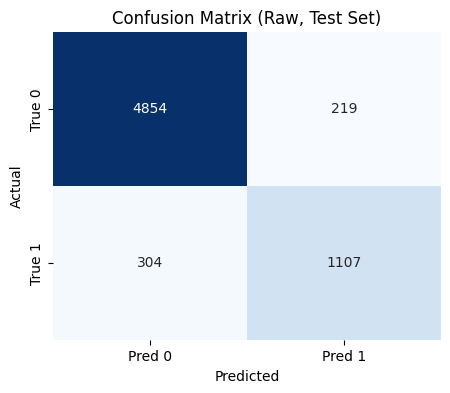

In [ ]:
# --- Model performance (Test) ---
print("=== Model Performance (Test) ===")
for name, prob in [
    ("Raw", proba_raw),
    ("Platt", proba_platt),
    ("Isotonic", proba_iso),
    ("Venn-Abers IVAP", p_va_ind),
    ("Venn-Abers CVAP", p_va_cross),
]:
    print(name, model_metrics(y_te, prob, threshold=0.5))

# --- Confusion Matrix (örnek Raw için, diğerleri de benzer yapılabilir) ---
y_pred_raw = (proba_raw >= 0.47).astype(int)
cm = confusion_matrix(y_te, y_pred_raw)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Raw, Test Set)")
plt.show()



Calibration Performance (Test Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.2238,0.0648,0.1437
Platt Scaling,0.2069,0.0568,0.1148
Isotonic Regression,0.2465,0.0544,0.0535
Venn-Abers (IVAP),0.2292,0.0622,0.0857
Venn-Abers (CVAP),0.1947,0.0548,0.0319


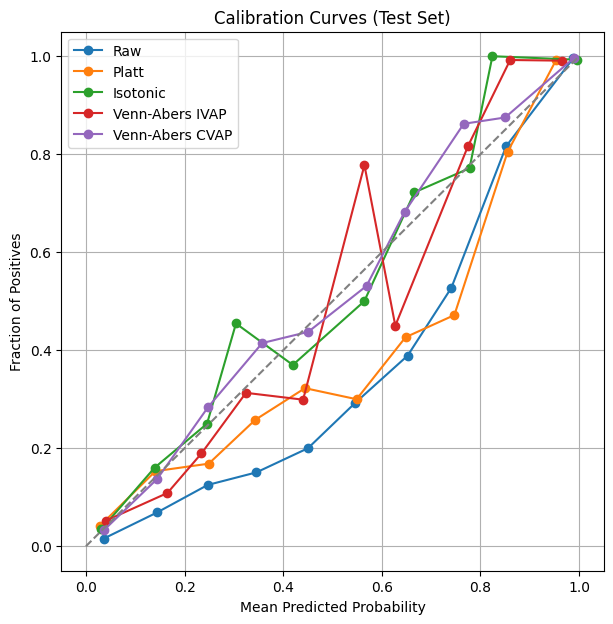

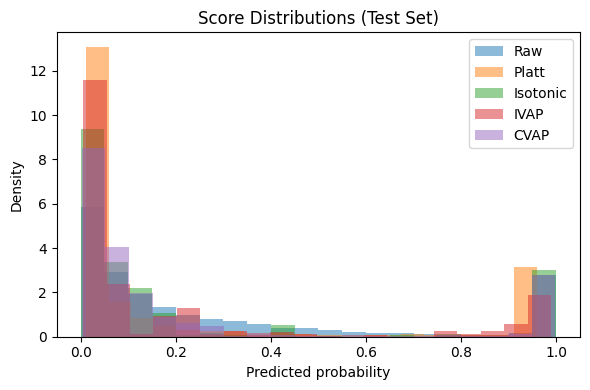

In [18]:
results = []
results.append(calibration_metrics(y_te, proba_raw,      "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_te, proba_platt,    "Platt Scaling"))
results.append(calibration_metrics(y_te, proba_iso,      "Isotonic Regression"))
results.append(calibration_metrics(y_te, p_va_ind,       "Venn-Abers (IVAP)"))
results.append(calibration_metrics(y_te, p_va_cross,     "Venn-Abers (CVAP)"))

calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Test Set):")
display(calib_df)

# --- Calibration Curves ---
plt.figure(figsize=(7,7))
for proba, name in [
    (proba_raw, "Raw"),
    (proba_platt, "Platt"),
    (proba_iso, "Isotonic"),
    (p_va_ind, "Venn-Abers IVAP"),
    (p_va_cross, "Venn-Abers CVAP"),
]:
    prob_true, prob_pred = calibration_curve(y_te, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- ECE histogram ---
plt.figure(figsize=(6,4))
plt.hist(proba_raw, bins=20, alpha=0.5, label="Raw", density=True)
plt.hist(proba_platt, bins=20, alpha=0.5, label="Platt", density=True)
plt.hist(proba_iso, bins=20, alpha=0.5, label="Isotonic", density=True)
plt.hist(p_va_ind, bins=20, alpha=0.5, label="IVAP", density=True)
plt.hist(p_va_cross, bins=20, alpha=0.5, label="CVAP", density=True)
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.title("Score Distributions (Test Set)")
plt.legend()
plt.tight_layout(); plt.show()


In [19]:
# --- Validation CSV ---
val_df = pd.DataFrame({
    "ID": df_va[ID_COL].values,
    "raw_prob": xgb_model.predict_proba(X_va)[:,1],
    "platt_prob": platt.predict_proba(X_va)[:,1],
    "isotonic_prob": isotonic.predict_proba(X_va)[:,1],
    "va_ind_prob": va_ind.predict_proba(X_va)[:,1],
    "va_cross_prob": va_cross.predict_proba(X_va)[:,1],
})
val_df.to_csv("validation_calibration_outputs.csv", index=False)

# --- Test CSV ---
test_df = pd.DataFrame({
    "ID": df_te[ID_COL].values,
    "raw_prob": proba_raw,
    "platt_prob": proba_platt,
    "isotonic_prob": proba_iso,
    "va_ind_prob": p_va_ind,
    "va_cross_prob": p_va_cross,
})
test_df.to_csv("test_calibration_outputs.csv", index=False)
